In [11]:
import wandb
import datetime
import argparse
import numpy as np
from train_and_test import train_and_test
from helpers import get_NWP_data,get_rain_gauge_or_radar_data, sw_func,find_experiment_directory
from models.linear_model import linear_model
from evaluator import evaluate_results,only_MSE
from logger import log_results
import sys

# Fixed paramters
project = "Final Thesis Experiment"
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist = 60
t_roll = 24
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "RVK-BOD": [0, 15,  30,  45,  60,  75,  90,  105, 120, 135, 150],
}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = "1475_T"

# Cross-validation settings
fn_kfold = "TimeSeriesSplit"
folds = 5

# District heating model settings
cross_validation = {
    "fn_kfold": fn_kfold,
    "folds": folds,
}


experiment_dir = find_experiment_directory()
data_directory = f"{experiment_dir}/Data/"
save_dir = f"{experiment_dir}/predictions/"

class emptyclass():
    def __init__(self):
        pass
args = emptyclass
args.alpha = 0
# args.datasource = 'gauge'
args.datasource = 'gauge'
args.include = 'rth'
args.weights = 'same'
args.obs = 20
n_obs = args.obs

# Data source argument
if args.datasource == "NWP":
    X1, X2, X3, Y12 = get_NWP_data(
        threshold_dict,
        temperature_name,
        max_lag,
        pred_dist,
        d_start,d_end)
    rain_shape = (-1, pred_dist, 100)
    temp_shape = (-1, pred_dist, 1)
    patt_shape = (-1, pred_dist, 24)
elif args.datasource == "radar":
    pred_dist_tmp = 1
    X1,_,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end)
    rain_shape = (-1, n_obs* 20*20)
    temp_shape = (-1, n_obs* 1)
    patt_shape = (-1, n_obs* 24)
    
elif args.datasource == "gauge":
    pred_dist_tmp = 1
    _,X1,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end)
    rain_shape = (-1, n_obs, 1)
    temp_shape = (-1, n_obs, 1)
    patt_shape = (-1, n_obs, 24)

# Rainfall argument
if args.include == "r":
    input_data = [X1.reshape(rain_shape)]
elif args.include == "rt":
    input_data = [
        X1.reshape(rain_shape),
        X2.reshape(temp_shape)
        ]
elif args.include == "rth":
    input_data = [
        X1.reshape(rain_shape),
        X2.reshape(temp_shape),
        X3.reshape(patt_shape),
    ]
else:
    parser.print_help()
    sys.exit(1)


if args.weights == "same":
    relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
elif args.weights == "shi_mirror":
    relative_weights = [0.5, 1, 1.5, 2,4,6,8,10,12,15,20]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
else:
    parser.print_help()
    sys.exit(1)


In [12]:

early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 200,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }
config_conceptual = {
    "name": "Conceptual model",
    "cross_validation": cross_validation,
    "thresholds": thresholds,
    'early_stopper': early_stopper_params,
    'lr_inital_log': 1,
    'lr_final_log': -4.5,
    'lr_intervals': 100,
    'batch_size': 10,
    'epochs': 10,
    'random_seed':0,
    'pred_dist':pred_dist,
    'include' : 'rth',
}


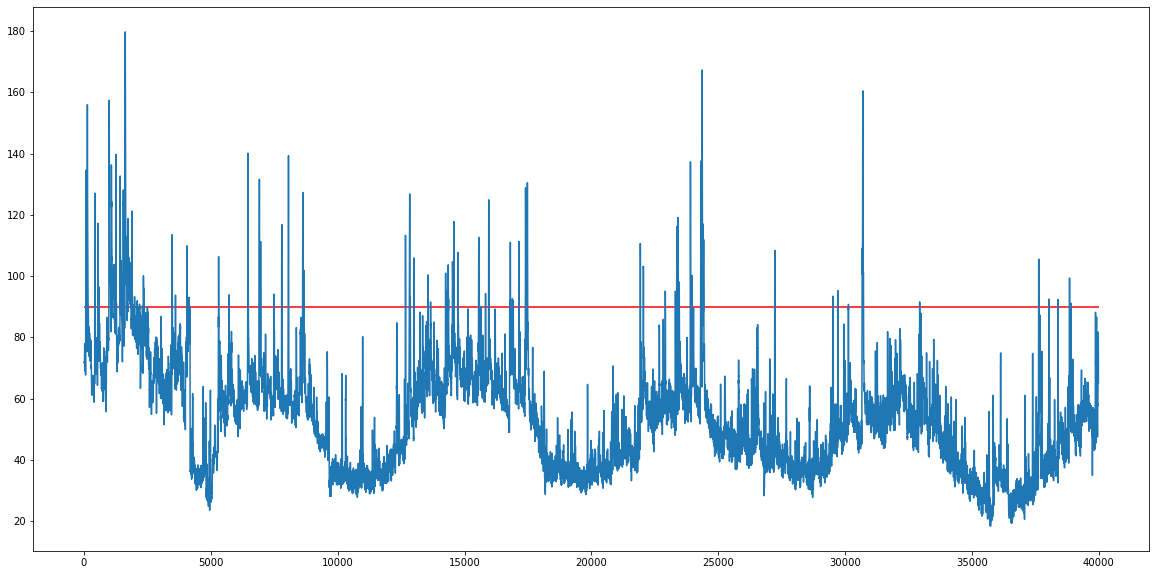

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
ys = pd.Series(Y12[:,1])
plt.figure(figsize=(20,10))
# plt.plot(ys)
plt.plot(ys.rolling(12).mean())
plt.hlines(90, 0,40000,color='red')

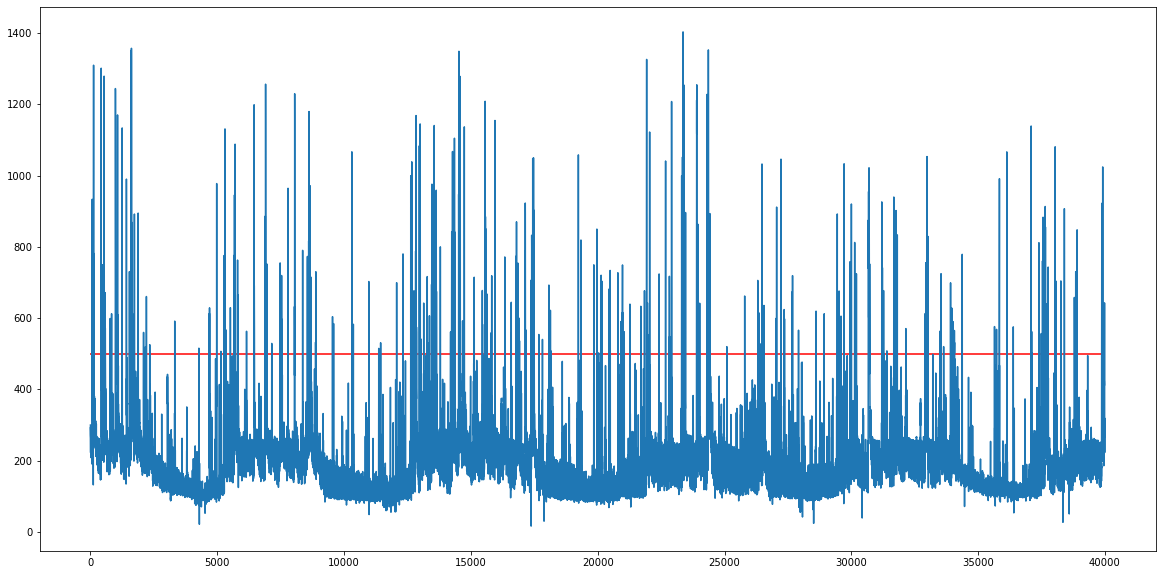

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
ys = pd.Series(Y12[:,0])
plt.figure(figsize=(20,10))
plt.plot(ys)
# plt.plot(ys.rolling(12).mean())
plt.hlines(500, 0,40000,color='red')

In [15]:
# 

In [16]:
# input_data

In [17]:
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
import tensorflow as tf
class quickmodel():
    def __init__(self, config,  **kwargs):
        self.config = config
        self.model = tf.keras.Sequential([tf.keras.layers.Input((args.obs,)),
            tf.keras.layers.Dense(1000,activation='sigmoid'),
            tf.keras.layers.Dense(1,activation='sigmoid')]
        )
        # self.model.compile(loss = tf.keras.losses.mse, optimizer = tf.keras.optimizers.Adam())
        self.model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam())
        
        self.lr_scheduler = LearningRateScheduler(self.lr_schedule, verbose=0)
        self.early_stopper = EarlyStopping(**config['early_stopper'])
        self.keywordarguments = {
            'epochs' : config['epochs'],
            'batch_size' : config['batch_size'],
            'shuffle' : True,
            'callbacks' : [
                self.lr_scheduler,
                self.early_stopper
                ],
        }
        
    def lr_schedule(self, epoch, lr):
        learning_rates = np.logspace(self.config['lr_inital_log'],
                                    self.config['lr_final_log'],
                                    self.config['lr_intervals'])
        epochs = self.config['epochs']
        return learning_rates[int(epoch/epochs * self.config['lr_intervals'])]

    def fit(self, fold_data, weight_func):
        X = fold_data['X_train']
        Y = fold_data['Y_train'] 
        X_val = fold_data['X_val']
        Y_val = fold_data['Y_val'] 
            
        fold_data['sample_weights'] = weight_func(Y)
                
        self.model.fit(X,Y,
                    validation_data = (X_val,Y_val),
                    sample_weight=fold_data['sample_weights'],
                    verbose = 1,
                    **self.keywordarguments,)
    
    def predict(self,x):
        y_pred =self.model.predict(x)
        return y_pred
quick_constructor = lambda : quickmodel(config_conceptual)


In [18]:
# y_cls = (Y12[:,1] > 100)*1
# results = train_and_test(quick_constructor,
#                         input_data=input_data[0].squeeze().copy(),
#                         output_data=y_cls,
#                         weight_func=sample_weights_function,
#                         config=config_conceptual)

In [19]:
# plt.figure(figsize=(20,10))
# ys = pd.Series(Y12[:,1])
# # plt.plot(Y12[:,1])
# plt.plot(ys.rolling(24).mean())
# plt.hlines(100, 0,40000,color='red')

In [20]:
above = len(Y12[Y12[:,0] > 800,0])
total = len(Y12)
above/total,above,total

(0.0076509563695461935, 306, 39995)

In [21]:
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
from sklearn.svm import SVR
class quickmodel():
    def __init__(self, config,  **kwargs):
        self.config = config
        self.model1 = SVR(epsilon = 10, gamma = 'scale', C = 100, shrinking=True,cache_size = 10000, verbose=True)
        self.model2 = SVR(epsilon = 5, gamma = 'scale', C = 100, shrinking=True,cache_size = 10000, verbose=True)
    
    
    def lr_schedule(self, epoch, lr):
        learning_rates = np.logspace(self.config['lr_inital_log'],
                                    self.config['lr_final_log'],
                                    self.config['lr_intervals'])
        epochs = self.config['epochs']
        return learning_rates[int(epoch/epochs * self.config['lr_intervals'])]
    
    
    def fit(self, fold_data, weight_func):
        X = fold_data['X_train'][0].squeeze()
        Y = fold_data['Y_train'] 
        X_val = fold_data['X_val'][0].squeeze()
        Y_val = fold_data['Y_val'] 
            
        fold_data['sample_weights'] = weight_func(Y)
                
        self.model1.fit(X,Y[:,0],sample_weight=fold_data['sample_weights'],)
        self.model2.fit(X,Y[:,1],sample_weight=fold_data['sample_weights'],)
    
    def predict(self,x):
        y_pred1 = self.model1.predict(x[0].squeeze())
        y_pred2 = self.model2.predict(x[0].squeeze())
        y_pred = np.concatenate([y_pred1.reshape(-1,1),y_pred2.reshape(-1,1)],axis=1)
        print(y_pred.shape)
        return y_pred
    
quick_constructor = lambda : quickmodel(config_conceptual)


In [22]:
[x.shape for x in input_data],Y12.shape

([(39995, 20, 1), (39995, 20, 1), (39995, 20, 24)], (39995, 2))

In [12]:

results = train_and_test(
    quick_constructor,
    input_data=input_data,
    output_data=Y12,
    weight_func=sample_weights_function,
    config=config_conceptual
)


[LibSVM][LibSVM](6670, 2)
(6665, 2)
[LibSVM][LibSVM](13335, 2)
(6665, 2)
[LibSVM][LibSVM](20000, 2)
(6665, 2)
[LibSVM][LibSVM](26665, 2)
(6665, 2)
[LibSVM][LibSVM](33330, 2)
(6665, 2)


In [28]:
sample_weights_function(np.array([500]))

ValueError: too many values to unpack (expected 2)

In [20]:
results['iop'][1]['Y_val']

array([[167.24704742,  54.9927597 ],
       [237.04847717,  56.90961838],
       [191.84173584,  57.06485367],
       ...,
       [138.6600647 ,  27.35819435],
       [105.96669817,  34.21297455],
       [109.84861755,  30.33374977]])

In [31]:
# thresholds

In [33]:
results_test = evaluate_results(results['iop'],thresholds,sample_weights_function)

In [34]:
[results_test['folds'][fold]['mean_squared_error'] for fold in results_test['folds']]

[4159.56753840585,
 3851.220656723187,
 3568.5865711955553,
 3591.500014319732,
 3369.50010449577]

In [35]:
[results_test['folds'][fold]['val_mean_squared_error'] for fold in results_test['folds']]

[5025.240202987113,
 4309.433167878967,
 4578.732253202042,
 3284.6602317950496,
 2371.987010891759]

In [ ]:
# Default SVR:
# and c default (likely 1)
# [5895.6871656784915,
#  5593.730946493181,
#  6774.325020198609,
#  4059.1800722631674,
#  3053.863155752353]

# With epsilon = 25 and 10
# and default gamma (Likely roughly: 1/(input_data[0].squeeze().var()*input_data[0].squeeze().shape[1]) = 0.373)
# and c default (likely 1)
# Train:
# [7269.240415645596,
#  6571.769358048115,
#  6073.613235457583,
#  6227.350891273479,
#  5784.394570091941]
# validation:
# [5874.639427895591,
#  5586.496371292793,
#  6794.530696952505,
#  4081.4862426004297,
#  3045.640780729764]

# With epsilon = 25 and 10
# and gamma = 0.5
# and c default (likely 1)
# Train:
# [7591.467881828028,
#  7540.995522855408,
#  6753.937303039502,
#  6663.688073691801,
#  5980.694300711352]
# # validation:
# [5941.832132403944,
#  6679.559325717296,
#  7171.908606603682,
#  4029.434732761191,
#  3281.230326741533]

# With epsilon = 25 and 10
# and gamma = 0.1
# and c default (likely 1)
# Train:
# [8797.714507426323,
#  8490.272782804193,
#  7830.304891231789,
#  7839.203943688201,
#  7171.847899817762]
# # validation:
# [6863.415690025588,
#  7519.065839175914,
#  8201.588308170285,
#  4953.05115183899,
#  4001.1064262093014]

# With epsilon = 25 and 10
# and gamma = 'scale'
# and C = 10
# Train:
# [6240.718144065216,
#  5635.696778455273,
#  5105.197615047907,
#  5217.927444350291,
#  4828.229636142454]
# # validation:
# [5374.465098939426,
#  4800.120225345782,
#  6011.7445115986775,
#  3518.4328699233106,
#  2561.9376080529614]

# With epsilon = 25 and 10
# and gamma = 'scale'
# and C = 100
# Train:
# [4179.614284342375,
#  3847.5729088051503,
#  3538.007702664353,
#  3705.720966205732,
#  3465.394661873149]
# validation:
# [5021.214077751341,
#  4213.850404924638,
#  5321.069148727724,
#  3266.8414115565206,
#  2363.628924748556]


# Runtime very long (>30 minutes)
# With epsilon = 25 and 10
# and gamma = 'scale'
# and C = 1000
# Train:
# [2100.5647544279273,
#  2165.4599237628067,
#  2176.82753800263,
#  2262.9862871337978,
#  2193.4126757889617]
# validation:
# [5297.608515383721,
#  4297.459137649834,
#  5133.032746497317,
#  3692.0333025779028,
#  2667.3659880351684]



# With epsilon = 50 and 20
# and gamma = 'scale'
# and C = 100
# Train:
# [4184.02320363967,
#  3854.6701318195405,
#  3560.970024401952,
#  3723.910756180464,
#  3480.6177794076493]
# validation:
# [5042.353597691423,
#  4143.861324623725,
#  5302.469609607898,
#  3264.5264095704074,
#  2390.304749247694]


# With epsilon = 10 and 5
# and gamma = 'scale'
# and C = 100
# Train:
# [4179.7355558953095,
#  3862.641461048669,
#  3542.1422687386194,
#  3714.6448367783573,
#  3471.2555467267366]
# validation:
# [5022.453434821776,
#  4241.887511894613,
#  5342.839942746683,
#  3293.6862073612874,
#  2370.874303304962]


# With epsilon = 10 and 5
# and gamma = 'scale'
# and C = 100
# shrinkage = True
# Train:
# validation:

In [52]:
[results_test['folds'][fold]['val_mean_squared_error'] for fold in results_test['folds']]

[5895.6871656784915,
 5593.730946493181,
 6774.325020198609,
 4059.1800722631674,
 3053.863155752353]

In [70]:
[results_test['folds'][fold]['val_mean_squared_error'] for fold in results_test['folds']]

[3861.352510960945,
 3451.495038372968,
 4544.557758670781,
 2428.9617182960296,
 2178.681664883794]

In [ ]:
results_test

In [43]:
# n = len(input_data)
# model.fit(input_data[:n//2],Y12[:n//2],
#           validation_data = (input_data[n//2:],Y12[n//2:]),
#           batch_size=128,epochs=100)

Epoch 1/100
157/157 [==============================] - 1s 3ms/step - loss: 30890.7910 - val_loss: 24659.1113
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 27150.2930 - val_loss: 20722.7129
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 22794.0469 - val_loss: 17103.7012
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 19123.2012 - val_loss: 14252.3506
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 16277.6133 - val_loss: 12060.0605
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 14082.4785 - val_loss: 10356.7852
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 12379.3701 - val_loss: 9042.5596
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 11067.3369 - val_loss: 8051.9595
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 10070.0908 - val_loss: 7324.1338
Epoch 10/100
157/157 [

In [ ]:


# config_linear.update(vars(args))
# run = wandb.init(config=config_linear, project = project)
# config_linear = wandb.config

linear_model_constructor = lambda : linear_model(config_linear)

linear_results = train_and_test(
    model_constructor=linear_model_constructor,
    input_data=input_data,
    output_data=Y12,
    weight_func=sample_weights_function,
    config=config_linear
)
predictions_and_targets = {fold_key:{key:value for key,value in fold.items() if ('Y_' in key)} for fold_key,fold in linear_results['iop'].items() if 'y_'}
file_name = f'linear_model_{args.weights}_{args.datasource}_{args.include}_{args.alpha}_{args.obs}'
np.save(save_dir + file_name,predictions_and_targets, allow_pickle=True)

# minimum logging (just summary stats)
minimum_eval_dict = only_MSE(linear_results["iop"], sample_weights_function)
run = wandb.init(config=config_linear, project = project)
wandb.log(minimum_eval_dict['summary'])
run.finish()


In [1]:
import wandb
import datetime
import argparse
import numpy as np
from train_and_test import train_and_test
from helpers import get_NWP_data, sw_func
from models.linear_model import linear_model
from evaluator import evaluate_results
from logger import log_results
import sys
from logger import *
import pandas as pd

# Fixed paramters
project = "Experiment 3 - CSI model selection and summary statistics"
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist = 60
t_roll = 24
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 600, 800, 1000],
    "RVK-BOD": [0, 25, 50, 75, 100, 125, 150, 200],
}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = "1475_T"

# Cross-validation settings
fn_kfold = "TimeSeriesSplit"
folds = 5

# District heating model settings
cross_validation = {
    "fn_kfold": fn_kfold,
    "folds": folds,
}


data_directory = (
    "C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/Data/"
)





In [2]:
class emptyclass():
    def __init__(self):
        pass
args = emptyclass

args.alpha = 0
args.datasource = 'gauge'
args.include = 'rain'
args.weights = 'same'
###################


# wandb.login()
config_linear = {
    "name": "Ridge regression with NWP",
    "cross_validation": cross_validation,
    "thresholds": thresholds,
}



# Data source argument
if args.datasource == "NWP":
    X1, X2, X3, Y12 = get_NWP_data(
        threshold_dict,
        temperature_name,
        max_lag,
        pred_dist,
        d_start,
        d_end,
        URL_save_data=data_directory,
    )
    rain_shape = (-1, pred_dist, 100)
    temp_shape = (-1, pred_dist, 1)
    patt_shape = (-1, pred_dist, 24)
else:
    raise NotImplementedError


# Rainfall argument
if args.include == "rain":
    input_data = [X1.reshape(rain_shape)]
elif args.include == "rain&temp":
    input_data = [X1.reshape(rain_shape), X2.reshape(rain_shape)]
elif args.include == "rain&temp&hour":
    input_data = [
        X1.reshape(rain_shape),
        X2.reshape(rain_shape),
        X3.reshape(rain_shape),
    ]
else:
    parser.print_help()
    sys.exit(1)


if args.weights == "same":
    relative_weights = [0.5, 1, 2, 5, 10, 15, 20, 30]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
elif args.weights:
    relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
else:
    parser.print_help()
    sys.exit(1)
    
args = vars(args)
args = {key:args[key] for key in args if '__' not in key}
# config_linear.update(vars(args))
config_linear.update(args)

def linear_model_constructor():
    return linear_model(config_linear['alpha'])

NotImplementedError: 

In [11]:
import tensorflow as tf
input_data[0].shape

(4948, 60, 100)

In [6]:
linear_results = train_and_test(
    model_constructor=linear_model_constructor,
    input_data=input_data,
    output_data=Y12,
    sample_weights_function=sample_weights_function,
    config=config_linear,
)


TypeError: train_and_test() missing 1 required positional argument: 'weight_func'

In [5]:
import matplotlib.pyplot as plt
run = wandb.init(config=config_linear, project = project)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sverrirhd (use `wandb login --relogin` to force relogin)
C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


# Evaluation

In [5]:
from evaluator import CLF_error

In [36]:
# results['iop'][0]['Y_val'] = results['iop'][0]['Y_val']

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
results['iop'][fold]['Y_val_cls']

In [6]:
def classification_stats_dict(iop,thresh = 5,sensor = 0,pred_start = 0,pred_end = 60):
    eta = 1e-7
    y_trues_val = np.concatenate([iop[fold]['Y_val_cls'] for fold in range(5)])[:,pred_start:pred_end, sensor, thresh].ravel()
    y_preds_val = np.concatenate([iop[fold]['Y_val_pred_cls'] for fold in range(5)])[:,pred_start:pred_end, sensor, thresh].ravel()

    y_trues_train = np.concatenate([iop[fold]['Y_train_cls'] for fold in range(5)])[:,pred_start:pred_end, sensor, thresh].ravel()
    y_preds_train = np.concatenate([iop[fold]['Y_train_pred_cls'] for fold in range(5)])[:,pred_start:pred_end, sensor, thresh].ravel()

    performance_dict_val = {}
    performance_dict_train = {}
    performance_dict_val['CSI'] = []
    performance_dict_train['CSI'] = []

    performance_dict_val['precision'] = []
    performance_dict_train['precision'] = []

    performance_dict_val['recall'] = []
    performance_dict_train['recall'] = []

    performance_dict_val['false positive rate'] = []
    performance_dict_train['false positive rate'] = []

    performance_dict_val['true positive rate'] = []
    performance_dict_train['true positive rate'] = []

    performance_dict_val['f1'] = []
    performance_dict_train['f1'] = []
    
    performance_dict_val['pred_thresh'] = []
    performance_dict_train['pred_thresh'] = []

    prediction_thresholds = np.linspace(0,1,1000)
    for pred_thresh in prediction_thresholds:
        TP, FP, TN, FN = CLF_error(y_trues_val, y_preds_val, pred_thresh)
        performance_dict_val['CSI'].append(TP/(TP + FP + FN + eta))
        performance_dict_val['precision'].append(TP/(TP+FP + eta))
        performance_dict_val['recall'].append(TP/(TP+FN + eta))
        performance_dict_val['false positive rate'].append(FP/(FP+TN + eta))
        performance_dict_val['true positive rate'].append(TP/(TP+FN + eta))
        performance_dict_val['f1'].append(TP/(TP + 1/2*(FP+FN + eta)))
        
        TP, FP, TN, FN = CLF_error(y_trues_train, y_preds_train, pred_thresh)
        performance_dict_train['CSI'].append(TP/(TP + FP + FN + eta))
        performance_dict_train['precision'].append(TP/(TP+FP + eta))
        performance_dict_train['recall'].append(TP/(TP+FN + eta))
        performance_dict_train['false positive rate'].append(FP/(FP+TN + eta))
        performance_dict_train['true positive rate'].append(TP/(TP+FN + eta))
        performance_dict_train['f1'].append(TP/(TP + 1/2*(FP+FN + eta)))
        
        
        performance_dict_val['pred_thresh'].append(pred_thresh)
        performance_dict_train['pred_thresh'].append(pred_thresh)
    return performance_dict_val,performance_dict_train

In [7]:
thresh = 5
sensor = 0

precision_val = []
recall_val = []
CSI_val = []

precision_train = []
recall_train = []
CSI_train = []

keys = [(0,6),(6,12),(12,24),(24,48),(48,60)]
PR_data_list = []
for pred_start,pred_end in keys:

    # performance_dict_val,performance_dict_train = classification_stats_dict(linear_results['iop'],thresh,sensor,pred_start,pred_end)
    performance_dict_val,performance_dict_train = classification_stats_dict(results['iop'],thresh,sensor,pred_start,pred_end)
    
    precision_val.append(performance_dict_val['precision'])
    recall_val.append(performance_dict_val['recall'])
    CSI_val.append(performance_dict_val['CSI'])
    
    precision_train.append(performance_dict_train['precision'])
    recall_train.append(performance_dict_train['recall'])
    CSI_train.append(performance_dict_train['CSI'])
    
    
precision_val = np.array(precision_val)
recall_val = np.array(recall_val)
CSI_val = np.array(CSI_val)

precision_train = np.array(precision_train)
recall_train = np.array(recall_train)
CSI_train = np.array(CSI_train)

labels = [f'from {i} to {j}' for i,j in keys]

KeyError: 'Y_val_cls'

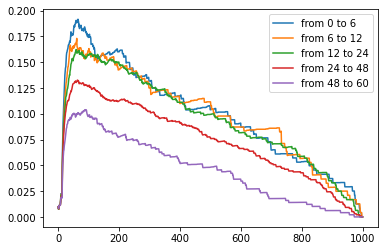

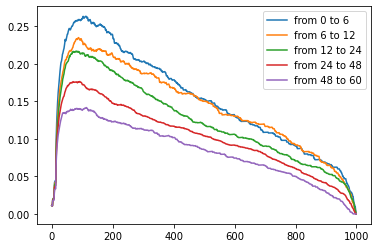

In [ ]:
plt.plot(CSI_val.T)
plt.legend(labels)
plt.show()
plt.plot(CSI_train.T)
plt.legend(labels)
plt.show()

In [ ]:

plt.plot([1, 2, 3, 4])
plt.ylabel("some interesting numbers")
wandb.log({"chart": plt})

In [21]:
# run = wandb.init(config=config_linear, project = project)

# import matplotlib.pyplot as plt
# fibonacci = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
# plt.plot(fibonacci)
# plt.ylabel('some interesting numbers')

# # Initialize a new run
# wandb.log({"plot": plt.gca()})
# wandb.finish()

In [23]:


import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line([1,2,3,4])
wandb.log({"chart3": wandb.Plotly.make_plot_media(fig)})
wandb.log({"chart2": fig})

wandb.finish()

In [ ]:
plotly.

In [ ]:
plt.plot(recall_train[i],precision_train[i],label=labels[i])
wandb.log({'precision recall test2':plt})

In [ ]:


# f = plt.figure(figsize=(12,5))
for i,(pred_start,pred_end) in enumerate(keys):
    line = plt.plot(recall_train[i],precision_train[i],label=labels[i])
    plt.plot(recall_val[i],precision_val[i],color = line[0].get_color(),
            #  linestyle=(0,(5,1)),
             alpha = 0.5,label = labels[i]+' (val)')
# plt.legend()
# plt.show()
wandb.log({'precision recall overview':plt})

In [ ]:
wandb.log(
    {
        "my_custom_plot_id2" : wandb.plot.line_series(
            xs=xs,
            ys=ys,
            keys=,
            title="Precision recall")
        },
    sync=True)

In [ ]:


thresh = 5
sensor = 0
prediction_distance = 45

performance_dict_val,performance_dict_train = classification_stats_dict(linear_results['iop'],thresh,sensor,prediction_distance)
    
PR_data = [[x,y] for x,y in zip(performance_dict_train['recall'],performance_dict_train['precision'])]

table = wandb.Table(data=PR_data, columns = ["recall", "precision"])
wandb.log({"my_custom_plot_id2" : wandb.plot.line(table, "recall", "precision",
                                                 title="Precision recall")},sync=True)

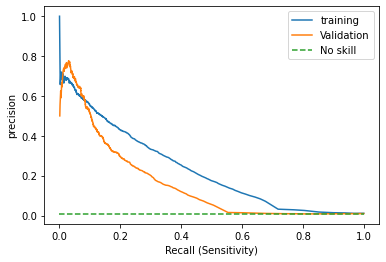

In [ ]:
import matplotlib.pyplot as plt
plt.plot(performance_dict_train['recall'],performance_dict_train['precision'])
plt.plot(performance_dict_val['recall'],performance_dict_val['precision'])

no_skill = len(y_true_val[y_true_val==1]) / len(y_true_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('precision')
plt.legend(['training','Validation','No skill'])
plt.show()

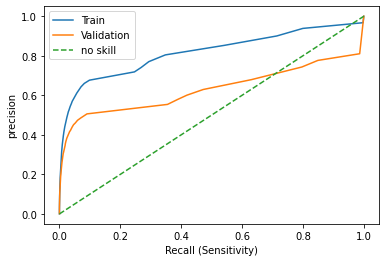

In [ ]:
plt.plot(performance_dict_train['false positive rate'],performance_dict_train['true positive rate'])
plt.plot(performance_dict_val['false positive rate'],performance_dict_val['true positive rate'])
plt.plot([0,1],[0,1], linestyle='--', label='No Skill')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('precision')
plt.legend(['Train','Validation','no skill'])

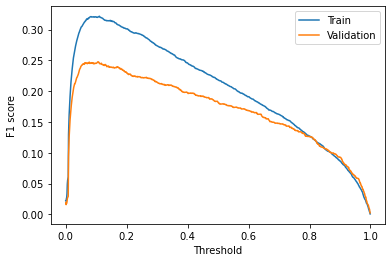

In [ ]:
plt.plot(prediction_thresholds,performance_dict_train['f1'])
plt.plot(prediction_thresholds,performance_dict_val['f1'])
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.legend(['Train','Validation','no skill'])

In [ ]:
linear_eval_dict = evaluate_results(
    linear_results["iop"], config_linear["thresholds"], sample_weights_function,
)

In [ ]:

# wandb.config.update(args)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sverrirhd (use `wandb login --relogin` to force relogin)
C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
wandb.log(linear_eval_dict['summary'])

fold_profile_table_list = []
fold_stats_table_list = []
for fold in linear_eval_dict['folds']:
        fold_evaluation_stats = linear_eval_dict['folds'][fold]
        # non_profile_keys
        non_profile_stats = {key:fold_evaluation_stats[key] for key in fold_evaluation_stats if (('profile' not in key) and ('fold_' not in key))}
        fold_stats_table_list.append(non_profile_stats)
        
                
        df_stats = pd.DataFrame({key:fold_evaluation_stats[key] for key in fold_evaluation_stats if 'profile' in key})
        df_stats = df_stats.loc[:,['mean_squared_error_profile','val_mean_squared_error_profile',
                        'mean_absolute_error_profile','val_mean_absolute_error_profile',]]
        df_stats.loc[:,'fold'] = fold
        df_stats.loc[:,'step'] = np.arange(len(df_stats))
        fold_profile_table_list.append(df_stats)
        
        # log_MSE_profile(fold_evaluation_stats)
        # log_MAE_profile(fold_evaluation_stats)

        # log_MSE(fold_evaluation_stats)
        # log_MAE(fold_evaluation_stats)
        
df_stats_combined = pd.DataFrame(fold_stats_table_list)
fold_stat_table = wandb.Table(data = df_stats_combined.values,columns=df_stats_combined.columns.tolist())
wandb.log({'fold_stats':fold_stat_table})

df_profiles_combined = pd.concat(fold_profile_table_list)
fold_profile_table = wandb.Table(data = df_profiles_combined.values,columns=df_profiles_combined.columns.tolist())
wandb.log({'fold_profiles':fold_profile_table})
run.finish()

In [ ]:
# ROC-CURVE
# F1 curve
# Precision-Recall curve

In [ ]:
# iop = linear_results['iop']

# prediction_dataframe_list = []
# for fold in iop:
#     fold_data = iop[fold]
#     prediction_dict = {key:fold_data[key] for key in fold_data if (('Y_val' in key) and ('cls' not in key))}
    
#     for value_kind in prediction_dict:
#         tmp_data = prediction_dict[value_kind]
#         if tmp_data.ndim == 3:
#             n,f,s = tmp_data.shape
#             sample = np.arange(n)
#             forecast_distance = np.arange(f)
#             sensor = np.arange(s)
            
#             x_samp,x_fore,x_sens = np.meshgrid(sample,forecast_distance,sensor,indexing='ij')
#             prediction_coords = np.c_[x_samp[...,np.newaxis],x_fore[...,np.newaxis],x_sens[...,np.newaxis]].reshape(-1,3)
        
#             data = np.concatenate([prediction_coords,tmp_data.reshape(-1,1)],axis=-1)
#             df_data = pd.DataFrame(data,columns=['sample_number','prediction_distance','sensor_id','value'])
            
#         elif tmp_data.ndim == 4:
#             n,f,s,t = tmp_data.shape
#             sample = np.arange(n)
#             forecast_distance = np.arange(f)
#             sensor = np.arange(s)
#             threshold_number = np.arange(t)
            
#             x_samp,x_fore,x_sens,x_thresh = np.meshgrid(sample,
#                                                         forecast_distance,
#                                                         sensor,
#                                                         threshold_number,indexing='ij')
#             prediction_coords = np.c_[x_samp[...,np.newaxis],
#                                       x_fore[...,np.newaxis],
#                                       x_sens[...,np.newaxis],
#                                       x_thresh[...,np.newaxis]].reshape(-1,4)
        
#             data = np.concatenate([prediction_coords,tmp_data.reshape(-1,1)],axis=-1)
#             df_data = pd.DataFrame(data,columns=['sample_number',
#                                                  'prediction_distance',
#                                                  'sensor_id',
#                                                  'threshold_number',
#                                                  'value'])
            
            
        
#         df_data.loc[:,'fold'] = fold
#         df_data.loc[:,'value_kind'] = value_kind
#         prediction_dataframe_list.append(df_data)
# df_predictions_combined = pd.concat(prediction_dataframe_list)


# df_predictions_combined.loc[:,'sample_number'] = df_predictions_combined.loc[:,'sample_number'].astype('int16')
# df_predictions_combined.loc[:,'prediction_distance'] = df_predictions_combined.loc[:,'prediction_distance'].astype('int8')
# df_predictions_combined.loc[:,'sensor_id'] = df_predictions_combined.loc[:,'sensor_id'].astype('category')
# df_predictions_combined.loc[:,'fold'] = df_predictions_combined.loc[:,'fold'].astype('category')
# # df_predictions_combined.loc[:,'threshold_number'] = df_predictions_combined.loc[:,'threshold_number'].astype('category')
# df_predictions_combined.loc[:,'value_kind'] = df_predictions_combined.loc[:,'value_kind'].astype('category')
# df_predictions_combined.loc[:,'value'] = df_predictions_combined.loc[:,'value'].astype('float32')

total_mean_absolute_error,▁
total_mean_squared_error,▁
total_mean_absolute_error,38.30159
total_mean_squared_error,5097.41118


In [27]:
# from helpers import get_rain_gauge_or_radar_data

In [28]:
import datetime
import numpy as np
project = "Experiment 3"
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist = 60
t_roll = 24
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 600, 800, 1000],
    "RVK-BOD": [0, 25, 50, 75, 100, 125, 150, 200],
}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = "1475_T"

# Cross-validation settings
fn_kfold = "TimeSeriesSplit"
folds = 5

data_directory = (
    "C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/Data/"
)

save_dir = 'C:/Users/sverrirhd/model results/'


In [32]:
# pred_dist_tmp = 1
# X1a,X1b,X2,X3,Y12 = get_rain_gauge_or_radar_data(threshold_dict,temperature_name,
#                                                       max_lag,pred_dist_tmp,d_start,d_end,
#                                                       URL_save_data=data_directory)

In [ ]:
variables = [X1a,X1b,X2,X3,Y12]
[i.shape for i in variables]

[(31658, 20, 20), (31658, 1), (31658, 1), (31658, 1, 24), (31658, 1, 2)]

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(X2)
# plt.plot(Y12[:,0])

In [47]:
def get_rain_gauge_or_radar_data(threshold_dict,
                                 temperature_name,
                                 obs,
                                 d_start,d_end,
                                 URL_save_data = './Data/',
                                 gauge_name = '1475_R_manual'):
    drainage_names = np.array(list(threshold_dict.keys()))
    
    # Radar data
    df_radar = np.load('C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Radar - runoff/20x20cappi_rainfall.pkl',allow_pickle=True)
    
    # rain_gauge data
    df_gauge = pd.read_pickle('C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/rain_gauges_combined.pkl')    
    
    # Temperature data (Added '_T' to differentiate between temperature and rain-gauge data)
    df_temperature = pd.read_pickle(
        URL_save_data + 'temperature_data.pkl').rename(rename_append('_T'), axis=1)

    # Drainage flow data (Drop MOS-HOl and KOP-HAB since they are irrelevant)
    df_target = pd.read_pickle(
        URL_save_data + 'drainage_Flow.pkl').drop(['MOS-HOL', 'KOP-HAB'], axis=1)

    Y_all = df_target.loc[d_start:d_end, drainage_names].copy()

    Xt_all = df_temperature.loc[d_start:d_end, temperature_name]#X.loc[d_start:d_end,temperature_name].copy()
    Xrg_all = df_gauge.loc[d_start:d_end,gauge_name].copy()
    Xra_all = df_radar.loc[d_start:d_end].copy()
    


    [Xt_all_seq_dirty,Y_all_seq_dirty,Xra_all_seq_dirty,Xrg_all_seq_dirty],dates_all_seq_dirty =\
        create_dataset([Xt_all,Y_all,Xra_all,Xrg_all],obs)

    # Take all but last value away from data where lagged value isn't necessary
    if type(Y_all_seq_dirty) == list:
        Y_all_seq_dirty = np.concatenate([i[:,:,np.newaxis] for i in Y_all_seq_dirty],axis=2)

    Y_all_seq_dirty = Y_all_seq_dirty[:,-1]

    # Drop rows with missing input data or all output data missing
    nan_rows = np.isnan(Xt_all_seq_dirty).any(axis=1) |\
        np.isnan(Xra_all_seq_dirty).any(axis=(1,2)) |\
            np.isnan(Xrg_all_seq_dirty).any(axis=1) |\
                np.isnan(Y_all_seq_dirty).any(axis=1)

    good_rows = ~nan_rows
    Xt_all_seq = Xt_all_seq_dirty[good_rows]
    Xra_all_seq = Xra_all_seq_dirty[good_rows]
    Xrg_all_seq = Xrg_all_seq_dirty[good_rows]

    Xt_all_single = Xt_all_seq_dirty[good_rows][:,-1]
    Xra_all_single = Xra_all_seq_dirty[good_rows][:,-1]
    Xrg_all_single = Xrg_all_seq_dirty[good_rows][:,-1]

    Y_all_single = Y_all_seq_dirty[good_rows]

    dates_all_seq = dates_all_seq_dirty[good_rows]

    hour_ohe_seq = OneHotEncoder().fit_transform(pd.DatetimeIndex(dates_all_seq.ravel()).hour.values.reshape(-1,1))
    hour_ohe_seq = hour_ohe_seq.toarray().reshape(-1,obs,24)
    hour_ohe_single = hour_ohe_seq[:,-1]

    X1a = Xra_all_seq
    X1b = Xrg_all_seq
    X2 = Xt_all_seq
    X3 = hour_ohe_seq
    Y12 = Y_all_single
    return X1a,X1b,X2,X3,Y12

def rename_append(x): return (lambda a: str(a) + x)
 
def create_dataset(series_list,lag):
    
    # Start by joining all data and recomputing with nan-values so timing isn't affected
    df_combined = pd.concat(series_list,axis=1)
    
    df_combined = df_combined.resample('1h').mean() 
    combined_index = df_combined.index
    date_sequences = sliding_window_view(combined_index, lag).squeeze()
    
    output_data = []
    for s in series_list:
        if isinstance(s,pd.Series):
            transformed = s.resample('1h').mean().loc[date_sequences.ravel()].values.reshape(date_sequences.shape)
            output_data.append(transformed)
        else:
            transformed = s.resample('1h').mean().loc[date_sequences.ravel()].values.reshape(date_sequences.shape + (s.shape[1],))
            output_data.append(transformed)
            
    return output_data,date_sequences

from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import OneHotEncoder

# Development & testing for new conceptual model

In [1]:
import wandb
import datetime
import argparse
import numpy as np
from train_and_test import train_and_test
from helpers import get_NWP_data,get_rain_gauge_or_radar_data, sw_func,find_experiment_directory
from models.linear_model import linear_model
from evaluator import evaluate_results,only_MSE
from logger import log_results
import sys

# Fixed paramters
project = "Final Thesis Experiment"
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist = 60
t_roll = 24
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 600, 800, 1000],
    "RVK-BOD": [0, 25, 50, 75, 100, 125, 150, 200],
}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = "1475_T"

# Cross-validation settings
fn_kfold = "TimeSeriesSplit"
folds = 5

# District heating model settings
cross_validation = {
    "fn_kfold": fn_kfold,
    "folds": folds,
}


experiment_dir = find_experiment_directory()
data_directory = f"{experiment_dir}/Data/"
save_dir = f"{experiment_dir}/predictions/"

class emptyclass():
    def __init__(self):
        pass
args = emptyclass
args.alpha = 0
# args.datasource = 'gauge'
args.datasource = 'radar'
args.include = 'r'
args.weights = 'same'
args.obs = 24
n_obs = args.obs


# Data source argument
if args.datasource == "NWP":
    X1, X2, X3, Y12 = get_NWP_data(threshold_dict,temperature_name,
                                    max_lag,pred_dist,d_start,d_end,)
    rain_shape = (-1, pred_dist, 100)
    temp_shape = (-1, pred_dist, 1)
    patt_shape = (-1, pred_dist, 24)
elif args.datasource == "radar":
    pred_dist_tmp = 1
    X1,_,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end,)
    rain_shape = (-1, n_obs, 20*20)
    temp_shape = (-1, n_obs, 1)
    patt_shape = (-1, n_obs, 24)
elif args.datasource == "gauge":
    pred_dist_tmp = 1
    _,X1,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end,)
    rain_shape = (-1, n_obs, 1)
    temp_shape = (-1, n_obs, 1)
    patt_shape = (-1, n_obs, 24)

input_data = [
    X1.reshape(rain_shape),
    X2.reshape(temp_shape),
    X3.reshape(patt_shape),
]

# if args.test:
#     n_subset = len(X1)//10
#     X1 = X1[:n_subset]
#     X2 = X2[:n_subset]
#     X3 = X3[:n_subset]
#     config_conceptual['cross_validation']['folds'] = 2
#     config_conceptual['epochs'] = 5

if args.weights == "same":
    relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
elif args.weights == "shi_mirror":
    relative_weights = [0.5, 1, 2, 5, 10, 15, 20, 30]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
else:
    parser.print_help()
    sys.exit(1)
    


In [2]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, TimeDistributed, Conv1D, Add, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow import random, losses
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow import device
import numpy as np


class conceptual_model_2():
    def __init__(self, config,  **kwargs):
        self.config = config
        random.set_seed(self.config['random_seed'])

        self.model1 = self.constuct_model()
        self.model2 = self.constuct_model()
    
        self.optimizer = Adam()
        self.model1.compile(optimizer=self.optimizer,
                           loss=losses.MSE)
        self.model2.compile(optimizer=self.optimizer,
                           loss=losses.MSE)

        self.lr_scheduler = LearningRateScheduler(
            self.lr_schedule, verbose=0)
        self.early_stopper = EarlyStopping(**config['early_stopper'])
        self.keywordarguments = {
            'epochs': config['epochs'],
            'batch_size': config['batch_size'],
            'shuffle': True,
            'callbacks': [
                self.lr_scheduler,
                self.early_stopper
            ],
        }
    def constuct_model(self):
        config = self.config
        
        if config['datasource'] == 'NWP':
            p = 125
            Input(shape=(config['pred_dist'],  p)),
            timesteps = config['pred_dist']
            padding = 'causal'

        else:
            if config['datasource'] == 'radar':
                p = 425
            elif config['datasource'] == 'gauge':
                p = 26
            timesteps = config['obs']
            padding = 'valid'


        tmp_model = Sequential(
            [
                Input(shape=(timesteps,  425)),
                Conv1D(
                    filters=config['filters'],
                    kernel_size=1,
                    padding=padding,
                    activation='sigmoid',
                    kernel_regularizer=l2(
                        config['alpha']
                    ),
                ),

                Flatten(),
                Dense(1, activation='linear'),
            ],
            'rainfall')
        
        return tmp_model
    def lr_schedule(self, epoch, lr):
        learning_rates = np.logspace(self.config['lr_inital_log'],
                                     self.config['lr_final_log'],
                                     self.config['lr_intervals'])
        epochs = self.config['epochs']
        return learning_rates[int(epoch/epochs * self.config['lr_intervals'])]

    def fit(self, fold_data, weight_func, debug=False):
        X = np.concatenate(fold_data['X_train'], -1)
        X_val = np.concatenate(fold_data['X_val'], -1)

        Y = fold_data['Y_train']
        Y_val = fold_data['Y_val']

        fold_data['sample_weights'] = weight_func(Y)

        verbose = 0
        if debug:
            verbose = 1
        self.model1.fit(X, Y[...,0],
                       validation_data=(X_val, Y_val[...,0]),
                       sample_weight=fold_data['sample_weights'],
                       verbose=1,
                       **self.keywordarguments,)
        self.model2.fit(X, Y[...,1],
                       validation_data=(X_val, Y_val[...,1]),
                       sample_weight=fold_data['sample_weights'],
                       verbose=1,
                       **self.keywordarguments,)

    def predict(self, X):
        Y_pred1 = self.model1.predict(np.concatenate(X, -1))
        Y_pred2 = self.model2.predict(np.concatenate(X, -1))
        Y_pred = np.concatenate([Y_pred1[...,np.newaxis],Y_pred2[...,np.newaxis]],axis=-1).squeeze()
        return Y_pred


In [3]:
early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 200,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }

tmp_config = {
    "name": "Conceptual model",
    "cross_validation": cross_validation,
    "thresholds": thresholds,
    'early_stopper': early_stopper_params,
    'lr_inital_log': -0.5,
    'lr_final_log': -4,
    'lr_intervals': 100,
    'batch_size': 512,
    'epochs': 100,
    'include' : 'rth',
    
    'random_seed':1,
    'obs' : n_obs,
    'filters' : 10,
    'datasource' : 'radar',
    'alpha' : 0.05,
}


model_constructor_tmp = lambda : conceptual_model_2(tmp_config)

with device('/CPU:0'):
    results = train_and_test(model_constructor_tmp,
                            input_data=input_data,
                            output_data=Y12,
                            weight_func=sample_weights_function,
                            config=tmp_config)

Epoch 1/100
13/13 [==============================] - 1s 45ms/step - loss: 29021.4336 - val_loss: 14318.8994
Epoch 2/100
13/13 [==============================] - 0s 23ms/step - loss: 17965.3906 - val_loss: 16194.1592
Epoch 3/100
13/13 [==============================] - 0s 19ms/step - loss: 15859.9570 - val_loss: 12453.6436
Epoch 4/100
13/13 [==============================] - 0s 21ms/step - loss: 14702.9316 - val_loss: 11941.3320
Epoch 5/100
13/13 [==============================] - 0s 22ms/step - loss: 13766.1016 - val_loss: 10918.8818
Epoch 6/100
13/13 [==============================] - 0s 21ms/step - loss: 12838.9023 - val_loss: 10196.6982
Epoch 7/100
13/13 [==============================] - 0s 21ms/step - loss: 12290.6572 - val_loss: 9828.3398
Epoch 8/100
13/13 [==============================] - 0s 21ms/step - loss: 11900.3916 - val_loss: 9511.8223
Epoch 9/100
13/13 [==============================] - 0s 20ms/step - loss: 11612.8994 - val_loss: 9288.1533
Epoch 10/100
13/13 [===========

In [5]:
results_test = evaluate_results(results['iop'],thresholds,sample_weights_function)
print([results_test['folds'][fold]['mean_squared_error'] for fold in results_test['folds']])
print([results_test['folds'][fold]['val_mean_squared_error'] for fold in results_test['folds']])

[5018.228878158727, 3922.6944059342686, 3557.9660237511716, 3744.840386451387, 3406.1638918309372]
[4289.070466526511, 4016.0103674186007, 5846.273043435215, 2725.712312193452, 2334.858324153662]


In [13]:
def compute_GSS(y_pred_cls, y_true_cls):
    TP = np.sum(y_pred_cls & y_true_cls)
    FP = np.sum(y_pred_cls & ~y_true_cls)
    FN = np.sum(~y_pred_cls & y_true_cls)
    TP_rand = (TP + FN)*(TP + FP)/(len(y_true_cls))
    
    GSS = (TP - TP_rand)/(TP + FN + FP - TP_rand)
    return GSS

def get_best_GSS(iop_fold, thresh):
    Y_train_pred = iop_fold['Y_train_pred'][:,sensor]
    Y_val_pred = iop_fold['Y_val_pred'][:,sensor] 
    Y_train = iop_fold['Y_train'][:,sensor] 
    Y_val = iop_fold['Y_val'][:,sensor]
    
    Y_val_cls = Y_val > thresh
    Y_train_cls = Y_train > thresh
    
    GSS_list_train = []
    GSS_list_val = []
    sorted_pred = sorted(Y_train_pred)
    for t in sorted_pred:
        Y_train_pred_cls = Y_train_pred > t
        Y_val_pred_cls = Y_val_pred > t
        GSS_train = compute_GSS(Y_train_pred_cls,Y_train_cls)
        GSS_val = compute_GSS(Y_val_pred_cls,Y_val_cls)
        GSS_list_train.append(GSS_train)
        GSS_list_val.append(GSS_val)
        
    best_thresh = np.argmax(GSS_list_train)
    GSS_train_best = GSS_list_train[best_thresh]
    GSS_val_best = GSS_list_val[best_thresh]
    return GSS_train_best,GSS_val_best

def plt_GSS(iop_fold, thresh,sensor):
    Y_train_pred = iop_fold['Y_train_pred'][:,sensor]
    Y_val_pred = iop_fold['Y_val_pred'][:,sensor] 
    Y_train = iop_fold['Y_train'][:,sensor] 
    Y_val = iop_fold['Y_val'][:,sensor]
    
    Y_val_cls = Y_val > thresh
    Y_train_cls = Y_train > thresh
    
    GSS_list_train = []
    GSS_list_val = []
    sorted_pred = sorted(Y_train_pred)
    for t in sorted_pred:
        Y_train_pred_cls = Y_train_pred > t
        Y_val_pred_cls = Y_val_pred > t
        GSS_train = compute_GSS(Y_train_pred_cls,Y_train_cls)
        GSS_val = compute_GSS(Y_val_pred_cls,Y_val_cls)
        GSS_list_train.append(GSS_train)
        GSS_list_val.append(GSS_val)
        
    plt.plot(sorted_pred,GSS_list_train)
    plt.plot(sorted_pred,GSS_list_val)
    plt.legend(['Train','Validation'])
    plt.show()

def get_average_best_GSS(iop,thresh,sensor):
    best_GSS_train_list = []
    best_GSS_val_list = []
    for fold in iop:

        iop_fold = iop[fold]

        GSS_train_best,GSS_val_best = get_best_GSS(iop_fold,thresh)
        best_GSS_train_list.append(GSS_train_best)
        best_GSS_val_list.append(GSS_val_best)
    average_GSS_train = np.mean(best_GSS_train_list)
    average_GSS_val = np.mean(best_GSS_val_list)
    return average_GSS_train,average_GSS_val

In [14]:
for fold in range(5):
    y_val_tmp = results['iop'][fold]['Y_val']
    n_above = (y_val_tmp >[500,90]).sum(axis=0)
    print(*n_above) #,n_above/len(y_val_tmp)*100)

188 201
186 297
190 216
146 151
118 99


# Persentage of data above a given threshold

In [48]:
(t1_last < y_val_tmp) & (y_val_tmp < t1)

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [46]:
t1_last < y_val_tmp < t1

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1]:
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "RVK-BOD": [0, 15,  30,  45,  60,  75,  90,  105, 120, 135, 150],
}
thresholds = np.array(list(threshold_dict.values())).T

t1_last = 0
t2_last = 0
for ts in thresholds[1:]:
    (t1, t2) = ts
    y_val_tmp = []
    for fold in range(5):
        y_val_tmp.append(results['iop'][fold]['Y_val'])

    y_val_tmp = np.concatenate(y_val_tmp)
    counts = (([t1_last,t2_last]< y_val_tmp) & (y_val_tmp < [t1, t2])).sum(axis=0)
    length = len(y_val_tmp)
    proportion = counts/length*100
    print('$'+str(t1_last)+'\leq{y}<'+str(t1)+'$', '$'+str(proportion[0].round(2))+'$')
    
    t1_last = t1
    t2_last = t2

counts = (([t1_last,t2_last]< y_val_tmp)).sum(axis=0)
length = len(y_val_tmp)
proportion = counts/length*100
print('$'+str(t1_last)+'<$', '$'+str(proportion[0].round(2))+'$')

print()

t1_last = 0
t2_last = 0
for ts in thresholds[1:]:
    (t1, t2) = ts
    y_val_tmp = []
    for fold in range(5):
        y_val_tmp.append(results['iop'][fold]['Y_val'])

    y_val_tmp = np.concatenate(y_val_tmp)
    counts = (([t1_last,t2_last]< y_val_tmp) & (y_val_tmp < [t1, t2])).sum(axis=0)
    length = len(y_val_tmp)
    proportion = counts/length*100
    print('$'+str(t2_last)+'\leq{y}<'+str(t2)+'$', '$'+str(proportion[1].round(2))+'$')
    
    t1_last = t1
    t2_last = t2

counts = (([t1_last,t2_last]< y_val_tmp)).sum(axis=0)
length = len(y_val_tmp)
proportion = counts/length*100
print('$'+str(t2_last)+'<$', '$'+str(proportion[1].round(2))+'$')

NameError: name 'np' is not defined

In [79]:
for i in range(10):
    print('$1$')
print()
for i in [0.5, 1, 1.5, 2,4,6,8,10,12,15,20]:
    print(f'${i}$')

$1$
$1$
$1$
$1$
$1$
$1$
$1$
$1$
$1$
$1$

$0.5$
$1$
$1.5$
$2$
$4$
$6$
$8$
$10$
$12$
$15$
$20$


In [61]:
sensor = 0
thresh = 400
# sensor = 1
# thresh = 100
get_average_best_GSS(results['iop'],thresh,sensor)

(0.3866722660603005, 0.28283106455152185)

In [38]:
# sensor = 0
# thresh = 400
sensor = 1
thresh = 90
get_average_best_GSS(results['iop'],thresh,sensor)

(0.3008462018310512, 0.24098487586046624)

In [39]:
sensor = 0
thresh = 400
get_average_best_GSS(results['iop'],thresh,sensor)

(0.569608045990986, 0.3163883233901163)

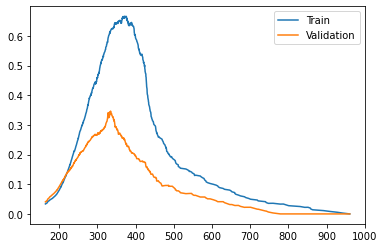

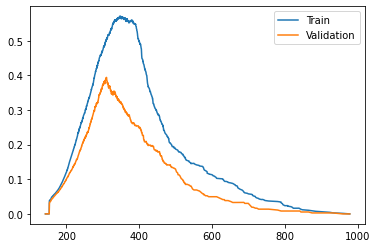

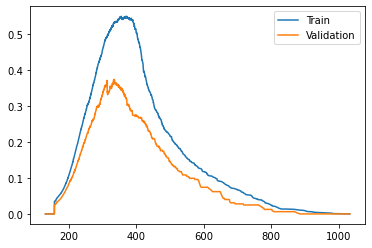

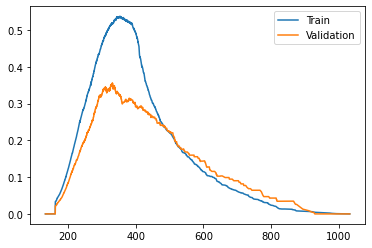

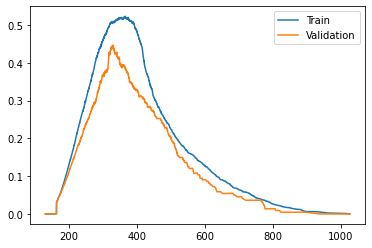

In [40]:
import matplotlib.pyplot as plt
plt_GSS(results['iop'][0],thresh,sensor)
plt_GSS(results['iop'][1],thresh,sensor)
plt_GSS(results['iop'][2],thresh,sensor)
plt_GSS(results['iop'][3],thresh,sensor)
plt_GSS(results['iop'][4],thresh,sensor)

In [26]:
X_new = np.concatenate(input_data,axis=-1).reshape(-1,20*425)


In [258]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

20 20


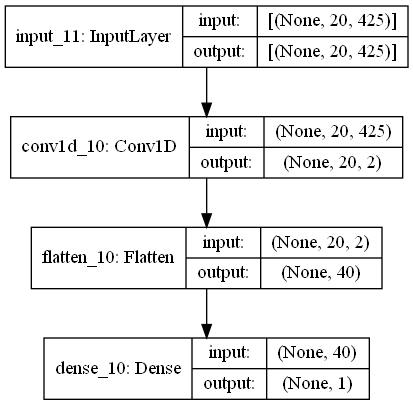

In [16]:
plot_model(model_constructor_tmp().model,show_shapes=True)

# Plotting model diagrams

In [15]:
# imports and urls
from keras import *
from keras.layers import * 
from keras.utils.vis_utils import plot_model
from keras.regularizers import*

diagram_dir = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/saved images/model diagrams/'

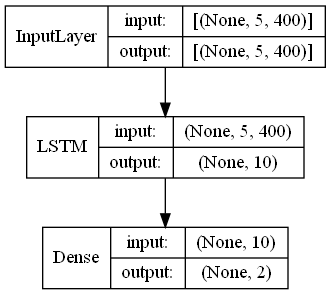

In [148]:

config = {'obs' : 5,'units' : 10}
p = 400

model = Sequential([
    Input((config['obs'],p)),
    LSTM(config['units']),
    Dense(2,activation='linear'),],'LSTM_regression')

plot_model(model,expand_nested=True, show_shapes=True, show_layer_names=False, to_file = diagram_dir + 'LSTM_sim.png')

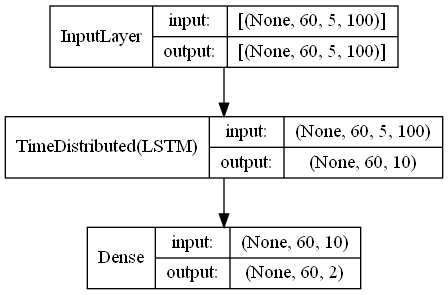

In [159]:

config = {'obs' : 5,'units' : 10}
p = 100
pred_dist_tmp = 60
model = Sequential([
    Input((pred_dist_tmp,
            config['obs'],
            p)),
    TimeDistributed(LSTM(config['units'])),
    Dense(2,activation='linear'),],'LSTM_regression')

plot_model(model,expand_nested=True, show_shapes=True, show_layer_names=False, to_file = diagram_dir + 'LSTM_for.png')

# Conceptual model

In [155]:
timesteps,  p

(5, 400)

In [33]:
config = {
    'obs':5,
    'datasource' : 'radar',
    'filters' : 2,
    'pred_dist' : 60,
    'alpha' : 0
}
if config['datasource'] == 'NWP':
    p = 100
    Input(shape = (config['pred_dist'],  p)),
    timesteps = config['pred_dist']
    padding = 'causal'
    
else:
    if config['datasource'] == 'radar':
        p = 400
    elif config['datasource'] == 'gauge':
        p = 1
    timesteps = config['obs']
    padding = 'valid'
    
if ((config['datasource'] == 'radar') or (config['datasource'] == 'NWP')):
    RR = Sequential([
        Input(shape = (timesteps,  p)),
        # Lambda(lambda x : tf.gather(x,[189,190,191,209,210,211,229,230,231],axis=-1)),
        Conv1D(
            filters=config['filters'],
            kernel_size=1,
            padding=padding,
            # activation='sigmoid',
            activation='sigmoid',
            # kernel_regularizer=l1(
            #     config['alpha']
            #     ),
            kernel_regularizer=l2(
                config['alpha']
                ),
            # kernel_constraint=tf.keras.constraints.NonNeg()
            ),
        
        # Flatten(),
        Permute((2,1)),
        LocallyConnected1D(1,1,1),
        Flatten(),
        # Dense(2,activation='linear'),
        # Reshape((-1,2))
        ],
                    'rainfall')
else:
    RR = Sequential([
        Input(shape = (timesteps,  p)),
        Flatten(),
        Dense(2,activation='linear'),
        # Reshape((-1,2))
        ],
                    'rainfall')
    
# DH = Sequential([
#     Input((timesteps, 1)),
#     Conv1D(filters = 50,
#            kernel_size = 1,
#            padding=padding,
#            activation='relu',
#            ),
#     Flatten(),
#     Dense(units=2,
#           activation = 'relu',),
#     # Reshape((-1,2)),
#     ], name='district_heating')

DH = Sequential([
    Input((timesteps, 1)),
    # Conv1D(filters = 1,
    #        kernel_size = 1,
    #        padding=padding,
    #        activation='linear',
    #        ),
    Flatten(),
    Dense(units=2,
            activation = 'linear',),
    # Reshape((-1,2)),
    ], name='district_heating')

DP = Sequential([
    Input((timesteps, 24)),
    Conv1D(filters = 2,
        #    kernel_size = 1,
            kernel_size = 1,
            padding=padding,
            activation='linear'),
    Flatten(),
    # Reshape((-1,2)),
    Dense(2)
    ])

# inputs

RR_input = Input((timesteps, p), name='rainfall_input')
DH_input = Input((timesteps, 1,), name='DH_input')
DP_input = Input((timesteps, 24), name='pattern_input')

RR_output = RR(RR_input)
DH_output = DH(DH_input)
DP_output = DP(DP_input)

combined_output = Add()([RR_output,DH_output,DP_output])
# combined_output = RR_output


model = Model([RR_input,DH_input,DP_input],combined_output)

plot_model(model,expand_nested=True, show_shapes=True, show_layer_names=False, to_file = diagram_dir + 'BAD_CON_for.png')

NameError: name 'Model' is not defined

## Fixed

In [30]:
from tensorflow.keras.regularizers import *
config = {
    'obs':5,
    'datasource' : 'radar',
    'filters' : 10,
    'pred_dist' : 60,
    'alpha' : 0
}
if config['datasource'] == 'NWP':
    p = 100
    Input(shape = (config['pred_dist'],  p)),
    timesteps = config['pred_dist']
    padding = 'causal'
    
else:
    if config['datasource'] == 'radar':
        p = 400
    elif config['datasource'] == 'gauge':
        p = 1
    timesteps = config['obs']
    padding = 'valid'
    

RR = Sequential([
    Input(shape = (timesteps,  p)),
    Conv1D(
        filters=config['filters'],
        kernel_size=1,
        padding=padding,
        activation='sigmoid',
        kernel_regularizer=l2(
            config['alpha']
            ),
        ),
    
    Flatten(),
    Dense(1,activation='linear'),
    ],
                'rainfall')

DH = Sequential([
    Input((timesteps, 1)),
    Conv1D(filters = 1,
           kernel_size = 1,
           padding=padding,
           activation='linear',
           ),
    Flatten(),
    Dense(units=1,
            activation = 'linear',),
    ], name='district_heating')


DP = Sequential([
    Input((timesteps, 24)),
    Conv1D(filters = 2,
            kernel_size = 1,
            padding=padding,
            activation='linear'),
    Flatten(),
    Dense(1)
    ])
# inputs

RR_input = Input((timesteps, p), name='rainfall_input')
DH_input = Input((timesteps, 1,), name='DH_input')
DP_input = Input((timesteps, 24), name='pattern_input')

RR_output = RR(RR_input)
DH_output = DH(DH_input)
DP_output = DP(DP_input)

combined_output = Add()([RR_output,DH_output,DP_output])
# combined_output = RR_output


model = Model([RR_input,DH_input,DP_input],combined_output)

plot_model(model,expand_nested=True, show_shapes=True, show_layer_names=False, to_file = diagram_dir + 'Fixed_CON_for1.png')

NameError: name 'Model' is not defined

## Simplified

In [28]:
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
config = {

    
    'obs':5,
    'datasource' : 'radar',
    'filters' : 10,
    'pred_dist' : 60,
    'alpha' : 0
}
timesteps = 5

RR = Sequential([
    Input(shape = (timesteps,  425)),
    Conv1D(
        filters=config['filters'],
        kernel_size=1,
        padding=padding,
        activation='sigmoid',
        kernel_regularizer=l2(
            config['alpha']
            ),
        ),
    
    Flatten(),
    Dense(1,activation='linear'),
    ],
                'rainfall')

plot_model(RR,expand_nested=True, show_shapes=True, show_layer_names=False, to_file = diagram_dir + 'Fixed_CON_for2.png')

NameError: name 'padding' is not defined

## Separated

In [32]:
config_conceptual

{'name': 'Conceptual model',
 'cross_validation': {'fn_kfold': 'TimeSeriesSplit', 'folds': 5},
 'thresholds': array([[   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000],
        [   0,   15,   30,   45,   60,   75,   90,  105,  120,  135,  150]]),
 'early_stopper': {'monitor': 'val_loss',
  'min_delta': 0,
  'patience': 200,
  'verbose': 0,
  'mode': 'min',
  'baseline': None,
  'restore_best_weights': True},
 'lr_inital_log': 1,
 'lr_final_log': -4.5,
 'lr_intervals': 100,
 'batch_size': 10,
 'epochs': 10,
 'random_seed': 0,
 'pred_dist': 60,
 'include': 'rth'}

In [48]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, TimeDistributed, Conv1D, Add, Reshape, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow import random, losses
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow import device
import numpy as np



class conceptual_model_2():
    def __init__(self, config,  **kwargs):
        self.config = config
        random.set_seed(self.config['random_seed'])

        self.model1 = self.constuct_model()
        self.model2 = self.constuct_model()
        self.model = self.parallelize(self.model1,self.model2)
    
        self.optimizer = Adam()
        self.model.compile(optimizer=self.optimizer,
                           loss=losses.MSE)

        self.lr_scheduler = LearningRateScheduler(
            self.lr_schedule, verbose=0)
        self.early_stopper = EarlyStopping(**config['early_stopper'])
        self.keywordarguments = {
            'epochs': config['epochs'],
            'batch_size': config['batch_size'],
            'shuffle': True,
            'callbacks': [
                self.lr_scheduler,
                self.early_stopper
            ],
        }
    def parallelize(self,m1,m2):
        inp = Input(m1.input_shape[1:])
        outp_1 = m1(inp)
        outp_2 = m2(inp)
        outp_con = Concatenate()([outp_1,outp_2])
        combined_model = Model(inp,outp_con)
        return combined_model
    
    def constuct_model(self):
        config = self.config
        
        if config['datasource'] == 'NWP':
            p = 125
            Input(shape=(config['pred_dist'],  p)),
            timesteps = config['pred_dist']
            padding = 'causal'

        else:
            if config['datasource'] == 'radar':
                p = 425
            elif config['datasource'] == 'gauge':
                p = 26
            timesteps = config['obs']
            padding = 'valid'


        tmp_model = Sequential(
            [
                Input(shape=(timesteps,  425)),
                Conv1D(
                    filters=config['filters'],
                    kernel_size=1,
                    padding=padding,
                    activation='sigmoid',
                    kernel_regularizer=l2(
                        config['alpha']
                    ),
                ),

                Flatten(),
                Dense(1, activation='linear'),
            ])
        
        return tmp_model
    def lr_schedule(self, epoch, lr):
        learning_rates = np.logspace(self.config['lr_inital_log'],
                                     self.config['lr_final_log'],
                                     self.config['lr_intervals'])
        epochs = self.config['epochs']
        return learning_rates[int(epoch/epochs * self.config['lr_intervals'])]

    def fit(self, fold_data, weight_func, debug=False):
        X = np.concatenate(fold_data['X_train'], -1)
        X_val = np.concatenate(fold_data['X_val'], -1)

        Y = fold_data['Y_train']
        Y_val = fold_data['Y_val']
        self.y_dim = Y_val.ndim

        fold_data['sample_weights'] = weight_func(Y)

        verbose = 0
        if debug:
            verbose = 1
        self.model.fit(X, Y,
                       validation_data=(X_val, Y_val),
                       sample_weight=fold_data['sample_weights'],
                       verbose=1,
                       **self.keywordarguments,)
        
        # self.model1.fit(X, Y[...,0],
        #                validation_data=(X_val, Y_val[...,0]),
        #                sample_weight=fold_data['sample_weights'],
        #                verbose=1,
        #                **self.keywordarguments,)
        # self.model2.fit(X, Y[...,1],
        #                validation_data=(X_val, Y_val[...,1]),
        #                sample_weight=fold_data['sample_weights'],
        #                verbose=1,
        #                **self.keywordarguments,)

    def predict(self, X):
        # Y_pred1 = self.model1.predict(np.concatenate(X, -1))
        # Y_pred2 = self.model2.predict(np.concatenate(X, -1))
        # Y_pred = np.concatenate([Y_pred1[...,np.newaxis],Y_pred2[...,np.newaxis]],axis=-1).squeeze()
        Y_pred = self.model.predict(np.concatenate(X, -1))
        if self.y_dim == 3:
            Y_pred = Y_pred.reshape(len(X),-1,2)
        else:
            Y_pred = Y_pred.reshape(len(X),2)
        return Y_pred


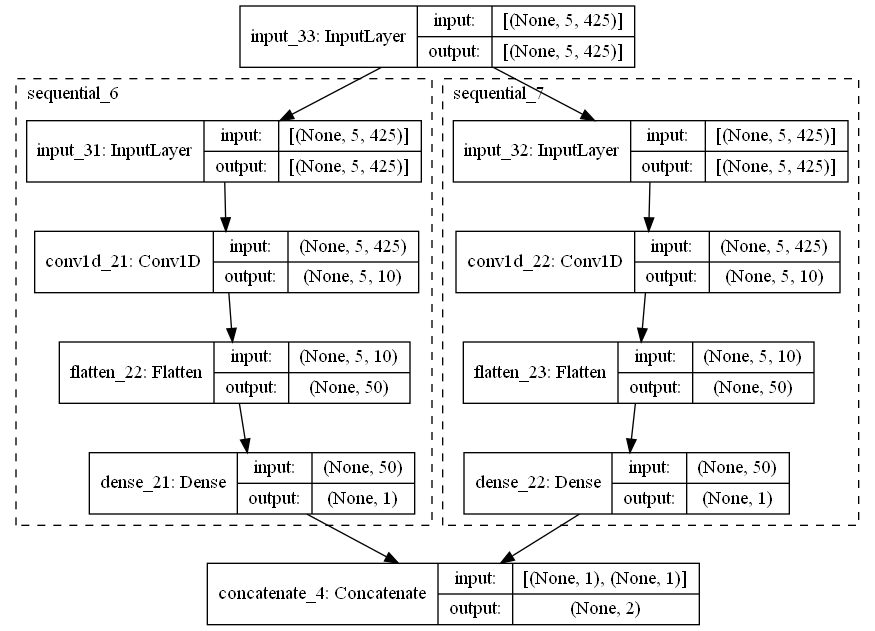

In [51]:
# from models.conceptual_model_2 import conceptual_model_2
from tensorflow.keras.utils import plot_model
config_conceptual = {
    "name": "Conceptual model",
    "cross_validation": cross_validation,
    "thresholds": thresholds,
    'early_stopper': early_stopper_params,
    'lr_inital_log': -1,
    'lr_final_log': -3.5,
    'lr_intervals': 100,
    'batch_size': 24*3,
    'epochs': 60,
    'random_seed':0,
    'pred_dist':pred_dist,
    'include' : 'rth',
    
    'eval_forecast_start': 24,
    'eval_forecast_end':30,
    
    'datasource' : 'radar',
    'obs' : 5,
    'filters' : 10,
    'alpha' : 0,
}

con_instance = conceptual_model_2(config_conceptual).model
plot_model(con_instance,expand_nested=True,show_shapes=True)

In [200]:
config = {
    'obs':5,
    'datasource' : 'radar',
    'filters' : 10,
    'pred_dist' : 60,
    'alpha' : 0
}

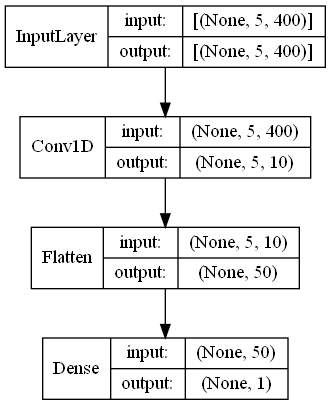

In [186]:
plot_model(RR,expand_nested=True, show_shapes=True, show_layer_names=False)

# Conceptual model recurrent

In [83]:
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Input,TimeDistributed,Conv1D, Add,Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow import random, losses
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow import device
import numpy as np


class conceptual_recurrent_model_2():
    def __init__(self, config,  **kwargs):
        self.config = config
        print(config)
        random.set_seed(self.config['random_seed'])
        
            
        self.model1 = self.construct_model()
        self.model2 = self.construct_model()
        self.model = self.parallelize(self.model1,self.model2)
    

        # inputs
        
        # self.model = Model([RR_input,DH_input,DP_input],combined_output)
        self.optimizer = Adam()
        self.model.compile(optimizer=self.optimizer,
                           loss=losses.MSE)

        self.lr_scheduler = LearningRateScheduler(self.lr_schedule, verbose=0)
        self.early_stopper = EarlyStopping(**config['early_stopper'])
        self.keywordarguments = {
            'epochs' : config['epochs'],
            'batch_size' : config['batch_size'],
            'shuffle' : True,
            'callbacks' : [
                self.lr_scheduler,
                self.early_stopper
                ],
        }
        
    def parallelize(self,m1,m2):
        inp = Input(m1.input_shape[1:])
        outp_1 = m1(inp)
        outp_2 = m2(inp)
        outp_con = Concatenate()([outp_1,outp_2])
        combined_model = Model(inp,outp_con)
        return combined_model
    
    def construct_model(self):
        config = self.config
        print(config['datasource'])
        if config['datasource'] == 'NWP':
            p = 125
            
            Input(shape = (config['pred_dist'],  p)),
            timesteps = config['pred_dist']
            padding = 'causal'
            return_seq = True
        else:
            if config['datasource'] == 'radar':
                p = 425
            elif config['datasource'] == 'gauge':
                p = 26
            timesteps = config['obs']
            padding = 'valid'
            return_seq = False
            
        print(return_seq)
        tmp_model = Sequential(
            [
                Input(shape=(timesteps,  p)),
                Conv1D(
                    filters=config['filters'],
                    kernel_size=1,
                    padding=padding,
                    activation='sigmoid',
                    kernel_regularizer=l2(
                        config['alpha']
                    ),
                ),
                LSTM(
                    units=1,
                    return_sequences = return_seq, 
                    # kernel_regularizer=l2(config['alpha'])
                ),
                

            ])
        
        return tmp_model
            
    def lr_schedule(self, epoch, lr):
        learning_rates = np.logspace(self.config['lr_inital_log'],
                                    self.config['lr_final_log'],
                                    self.config['lr_intervals'])
        epochs = self.config['epochs']
        return learning_rates[int(epoch/epochs * self.config['lr_intervals'])]

    
    def fit(self, fold_data, weight_func):
        X = fold_data['X_train']
        Y = fold_data['Y_train'] 
        X_val = fold_data['X_val']
        Y_val = fold_data['Y_val'] 
            
        fold_data['sample_weights'] = weight_func(Y)
        
        self.model.fit(X,Y,
                    validation_data = (X_val,Y_val),
                    sample_weight=fold_data['sample_weights'],
                    verbose = 0,
                    **self.keywordarguments,)

    def predict(self, X):
        Y_pred = self.model.predict(X)
        return Y_pred

    

{'name': 'Conceptual model', 'cross_validation': {'fn_kfold': 'TimeSeriesSplit', 'folds': 5}, 'thresholds': array([[   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000],
       [   0,   15,   30,   45,   60,   75,   90,  105,  120,  135,  150]]), 'early_stopper': {'monitor': 'val_loss', 'min_delta': 0, 'patience': 200, 'verbose': 0, 'mode': 'min', 'baseline': None, 'restore_best_weights': True}, 'lr_inital_log': -1, 'lr_final_log': -3.5, 'lr_intervals': 100, 'batch_size': 72, 'epochs': 60, 'random_seed': 0, 'pred_dist': 60, 'include': 'rth', 'eval_forecast_start': 24, 'eval_forecast_end': 30, 'datasource': 'radar', 'obs': 5, 'filters': 10, 'alpha': 0}
radar
False
radar
False


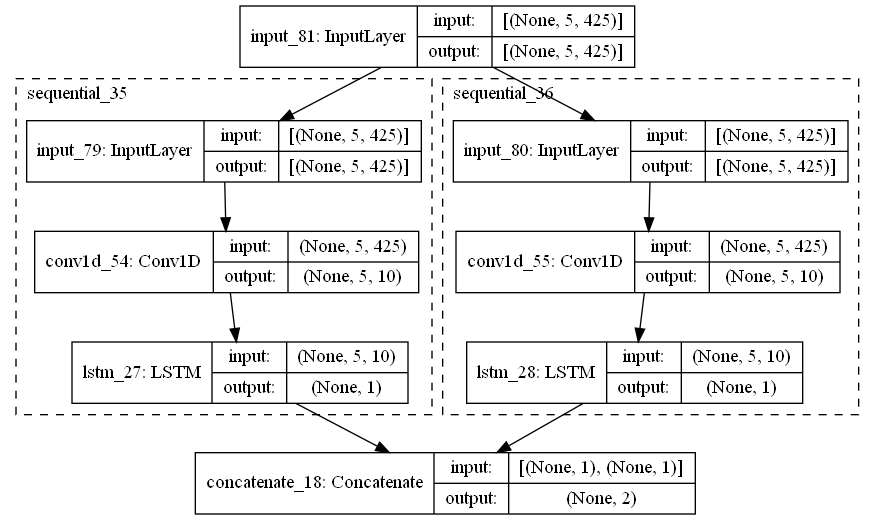

In [84]:
# from models.conceptual_recurrent_model import conceptual_recurrent_model
from tensorflow.keras.utils import plot_model
config_conceptual = {
    "name": "Conceptual model",
    "cross_validation": cross_validation,
    "thresholds": thresholds,
    'early_stopper': early_stopper_params,
    'lr_inital_log': -1,
    'lr_final_log': -3.5,
    'lr_intervals': 100,
    'batch_size': 24*3,
    'epochs': 60,
    'random_seed':0,
    'pred_dist':pred_dist,
    'include' : 'rth',
    
    'eval_forecast_start': 24,
    'eval_forecast_end':30,
    
    'datasource' : 'radar',
    'obs' : 5,
    'filters' : 10,
    'alpha' : 0,
}

con_instance = conceptual_recurrent_model_2(config_conceptual).model
plot_model(con_instance,expand_nested=True,show_shapes=True)

{'name': 'Conceptual model', 'cross_validation': {'fn_kfold': 'TimeSeriesSplit', 'folds': 5}, 'thresholds': array([[   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000],
       [   0,   15,   30,   45,   60,   75,   90,  105,  120,  135,  150]]), 'early_stopper': {'monitor': 'val_loss', 'min_delta': 0, 'patience': 200, 'verbose': 0, 'mode': 'min', 'baseline': None, 'restore_best_weights': True}, 'lr_inital_log': -1, 'lr_final_log': -3.5, 'lr_intervals': 100, 'batch_size': 72, 'epochs': 60, 'random_seed': 0, 'pred_dist': 60, 'include': 'rth', 'eval_forecast_start': 24, 'eval_forecast_end': 30, 'datasource': 'NWP', 'obs': 5, 'filters': 10, 'alpha': 0}
NWP
True
NWP
True


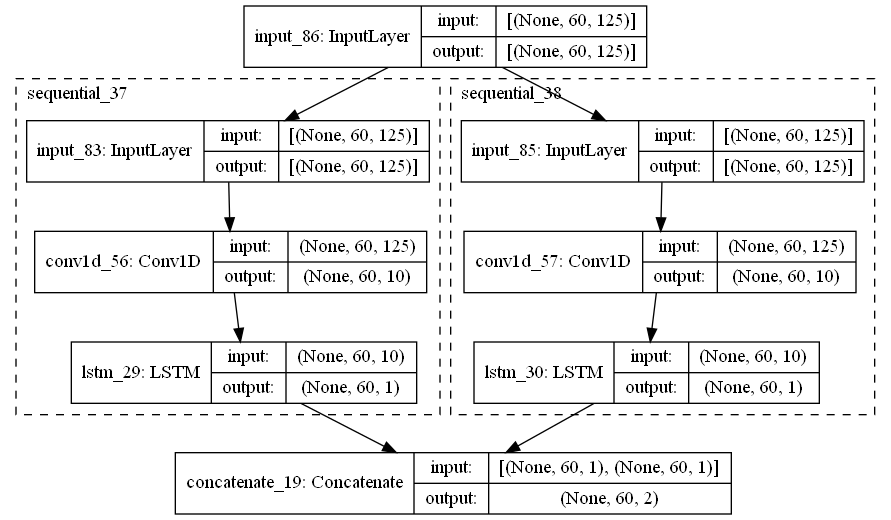

In [85]:
# from models.conceptual_recurrent_model import conceptual_recurrent_model
from tensorflow.keras.utils import plot_model
config_conceptual = {
    "name": "Conceptual model",
    "cross_validation": cross_validation,
    "thresholds": thresholds,
    'early_stopper': early_stopper_params,
    'lr_inital_log': -1,
    'lr_final_log': -3.5,
    'lr_intervals': 100,
    'batch_size': 24*3,
    'epochs': 60,
    'random_seed':0,
    'pred_dist':pred_dist,
    'include' : 'rth',
    
    'eval_forecast_start': 24,
    'eval_forecast_end':30,
    
    'datasource' : 'NWP',
    'obs' : 5,
    'filters' : 10,
    'alpha' : 0,
}

con_instance = conceptual_recurrent_model_2(config_conceptual).model
plot_model(con_instance,expand_nested=True,show_shapes=True)